In [1]:
import os
from time import perf_counter, perf_counter_ns
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks, resize
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from skimage.color import rgb2gray, rgb2hsv

In [2]:
org = io.imread('Images/RoadImages/test5.jpg')

In [3]:
def p2f(value: int) -> float:
    return value / 100

In [4]:
def get_red_parts(img: np.ndarray) -> np.ndarray:
    hsi = rgb2hsv(img)
    output = np.zeros_like(img)
    hue_rule = ((0 <= hsi[:, :, 0]) & (hsi[:, :, 0] <= 10/360)) | ((300/360 <= hsi[:, :, 0]) & (hsi[:, :, 0] <= 1))
    sat_rule = (p2f(25) <= hsi[:, :, 1]) & (hsi[:, :, 1] <= p2f(250))
    intens_rule = (p2f(30) < hsi[:, :, 2]) & (hsi[:, :, 2] <= p2f(200))
    indexes = hue_rule & sat_rule & intens_rule
    output[indexes] = img[indexes]
    output = np.sum(output, axis=2, keepdims=False)
    output[output > 0] = 1
    return output

In [5]:
def get_blue_parts(img: np.ndarray) -> np.ndarray:
    hsi = rgb2hsv(img)
    output = np.zeros_like(img)
    hue_rule = (190 / 360 <= hsi[:, :, 0]) & (hsi[:, :, 0] <= 260 / 360)
    sat_rule = (p2f(30) <= hsi[:, :, 1]) & (hsi[:, :, 1] <= p2f(250))
    intens_rule = (p2f(35) < hsi[:, :, 2]) & (hsi[:, :, 2] <= p2f(128))
    indexes = hue_rule & sat_rule & intens_rule
    output[indexes] = img[indexes]
    output = np.sum(output, axis=2, keepdims=False)
    output[output > 0] = 1
    return output

In [6]:
def get_yellow_parts(img: np.ndarray) -> np.ndarray:
    hsi = rgb2hsv(img)
    output = np.zeros_like(img)
    hue_rule = (40 / 360 <= hsi[:, :, 0]) & (hsi[:, :, 0] <= 65 / 360)
    sat_rule = (p2f(60) <= hsi[:, :, 1]) & (hsi[:, :, 1] <= p2f(250))
    intens_rule = (p2f(60) < hsi[:, :, 2]) & (hsi[:, :, 2] <= p2f(128))
    indexes = hue_rule & sat_rule & intens_rule
    output[indexes] = img[indexes]
    output = np.sum(output, axis=2, keepdims=False)
    output[output > 0] = 1
    return output

In [10]:
def display_masked_colors(image: np.ndarray) -> None:
    fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(ncols=2, nrows=2, figsize=(20, 15))

    ax0.imshow(image)
    ax0.set_title('original')
    ax0.axis('off')

    ax1.imshow(get_red_parts(image), cmap=plt.cm.gray)
    ax1.set_title('red channel')
    ax1.axis('off')

    ax2.imshow(get_blue_parts(image), cmap=plt.cm.gray)
    ax2.set_title('blue channel')
    ax2.axis('off')

    ax3.imshow(get_yellow_parts(image), cmap=plt.cm.gray)
    ax3.set_title('yellow channel')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

(764, 1366)


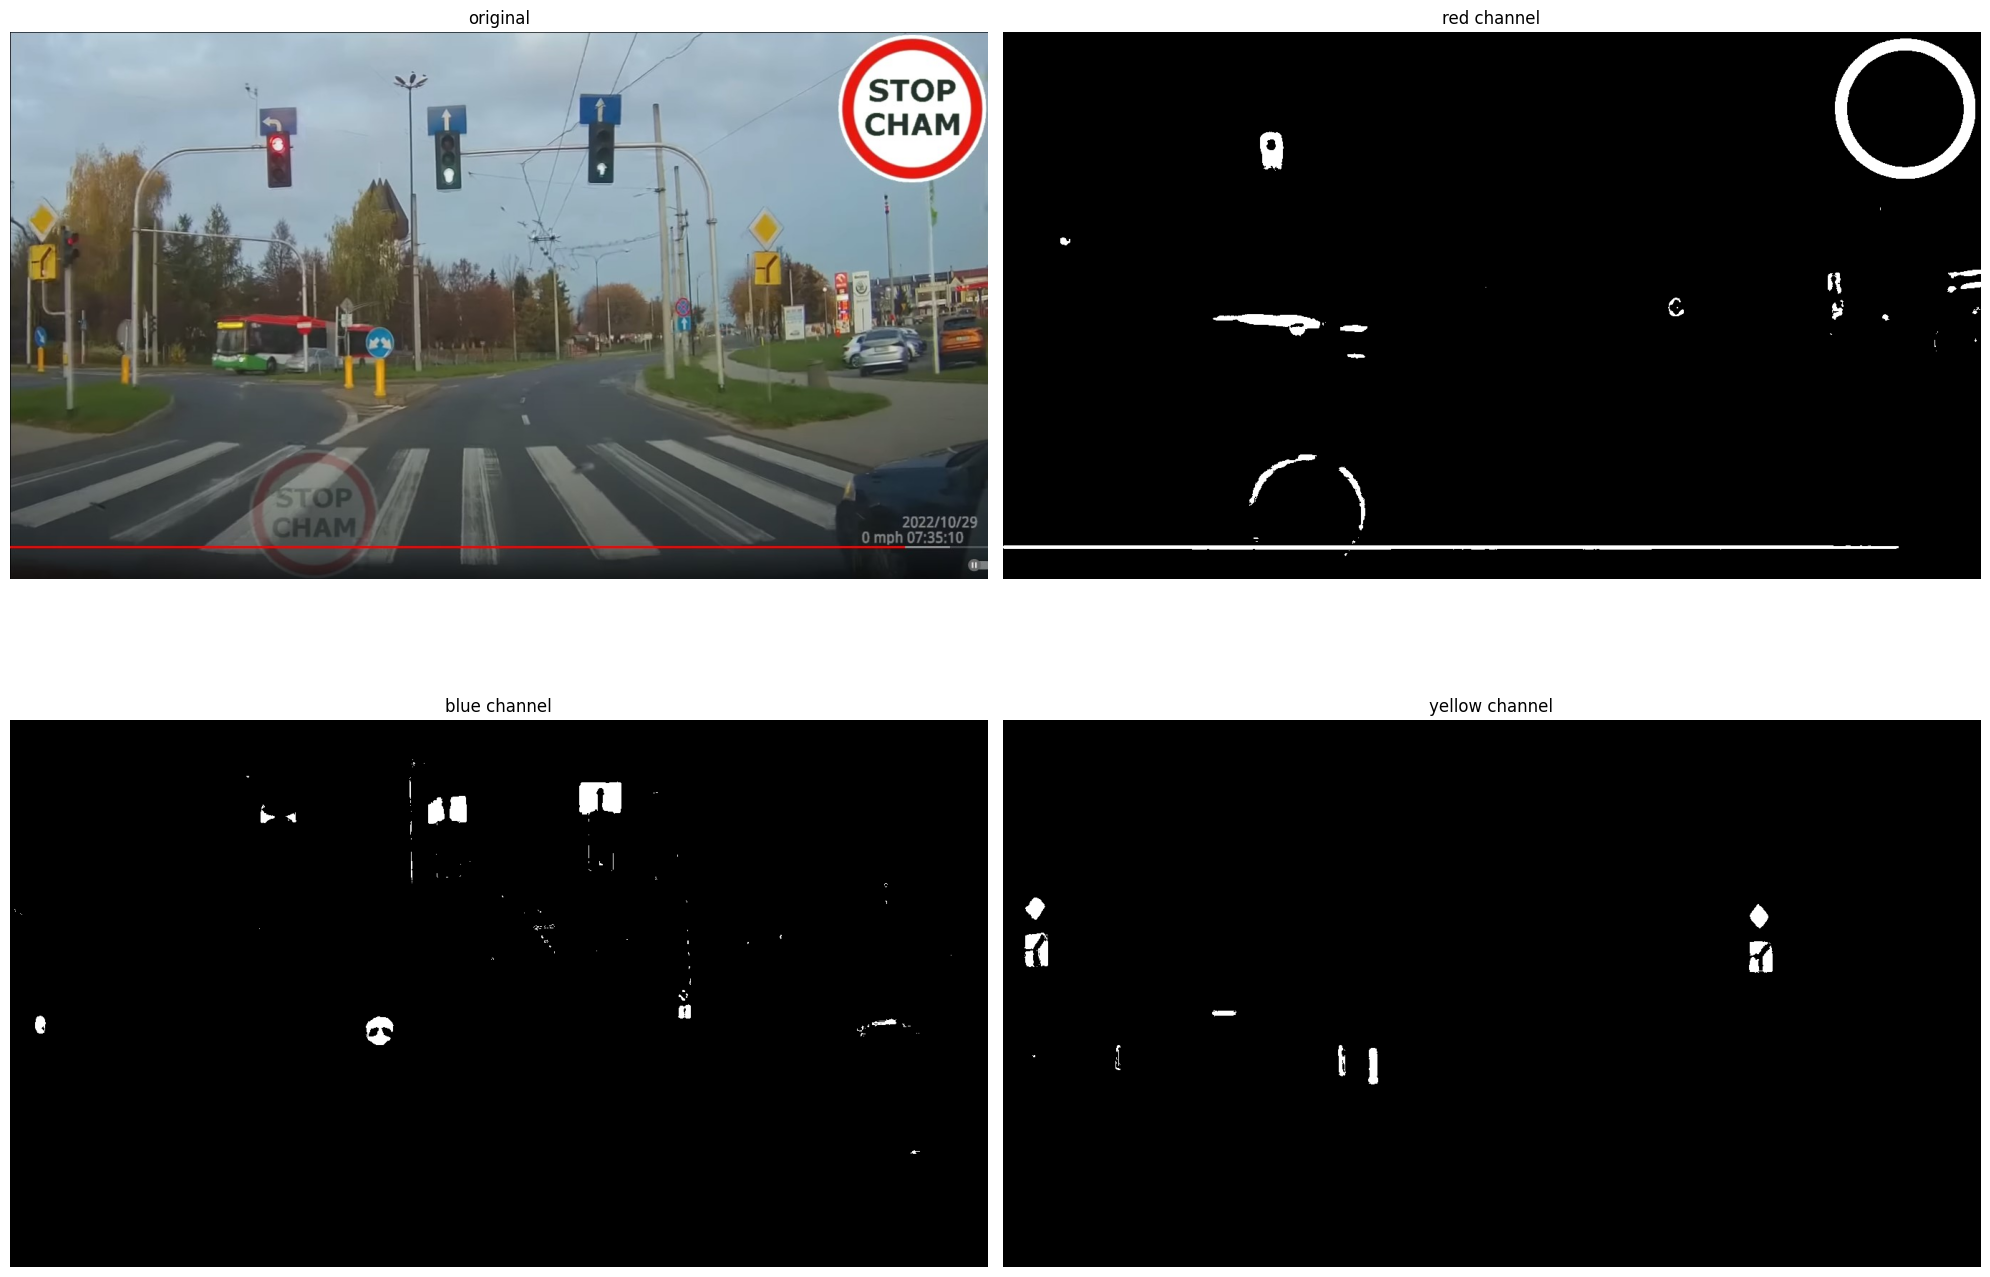

In [8]:
home_path = 'Images/RoadImages'
for file in [file for file in os.listdir(home_path) if 'test4' in file]:
    img = io.imread(os.path.join(home_path, file))
    display_masked_colors(image=img)

In [126]:
from itertools import product
import cv2


DIST_EPSILON = 0.05


def get_base_contours(path: str) -> dict:
    result = {}

    for filename in os.listdir(path):
        image_path = os.path.join(path, filename)

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, image = cv2.threshold(image, 150, 255, 0)
        contours, _ = cv2.findContours(image, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) == 1:
            result[f'{filename.removesuffix(".png")}'] = contours[0]
        else:
            raise ValueError(f'To many contours found in {image_path} image')
    return result


base_contours = get_base_contours(os.path.join('Images', 'Shapes'))
base_colors = {
    'red': (255, 0, 0),
    'yellow': (255, 255, 153),
    'blue': (0, 0, 255)
}


for filename in os.listdir(os.path.join('Images', 'RoadImages')):
    image_path = os.path.join(home_path, filename)
    img = io.imread(image_path)
    # display_masked_colors(image=img)
    img_copy = img.copy()

    masks = {
        'red': get_red_parts(img).astype(np.uint8),
        'yellow': get_yellow_parts(img).astype(np.uint8),
        'blue': get_blue_parts(img).astype(np.uint8),
    }

    for color_space, mask in masks.items():
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for base_contour, contour in product(base_contours.values(), contours):
            dist = cv2.matchShapes(base_contour, contour, cv2.CONTOURS_MATCH_I3, 0)

            if dist < DIST_EPSILON:
                x, y, w, h = cv2.boundingRect(contour)
                cv2.rectangle(img_copy, (x,y), (x+w, y+h), base_colors[color_space], 2)

    img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)
    cv2.imshow('', img_copy)
    cv2.waitKey(0)
    cv2.destroyAllWindows()